# Data Augmentation for Pool Detection Dataset

Data augmentation in the pool detection dataset containing 100 GPS images and its corresponding bounding boxes using the library `Albumentations`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')  # connect to drive

Mounted at /content/drive


In [2]:
%%capture
!unzip '/content/drive/MyDrive/Fuse AI Project/DatasetYOLO.zip'  # download the dataset

In [3]:
%%capture
!pip install albumentations  # download Albumentations

In [4]:
# Importing libraries

import albumentations as A
import cv2
import matplotlib.pyplot as plt

In [5]:
transforms = A.Compose([  # set of transformations to be applied
    A.HorizontalFlip(p=0.8),  # horizontal flip with a 80% of probability
    A.RandomBrightnessContrast(p=0.8)  # random brightness contrast with a 80% of probability
], bbox_params=A.BboxParams(format='yolo'))  # [x_center, y_center, width, height]  YOLO format]

In [6]:
def plot_bboxes(image, bboxes):
  """
  Plots the bounding boxes present in the images using OpenCV.

  params:
  - `image`: the original image.
  - `bboxes`: bounding boxes in the original image.

  return:
  - Plot of the annotated image.
  """
  image_with_box = image.copy()  # in order to not modify the original
  height, width, channels = image_with_box.shape

  for bbox in bboxes:
    top_left_x = int(width * (bbox[0] - 0.5 * bbox[2]))  # x_center - 0.5 * width
    top_left_y = int(height * (bbox[1] + 0.5 * bbox[3]))  # y_center + 0.5 * height
    bottom_right_x = int(width * (bbox[0] + 0.5 * bbox[2]))  # x_center + 0.5 * width
    bottom_right_y = int(height * (bbox[1] - 0.5 * bbox[3]))  # y_center - 0.5 * height
    cv2.rectangle(image_with_box, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 255, 0), 2)

  plt.imshow(image_with_box)

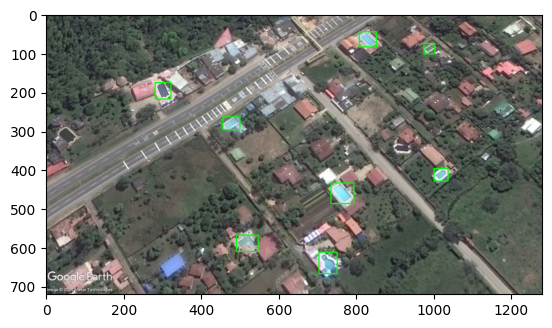

In [7]:
# Image to be transformed (example)
image = cv2.imread('/content/DatasetYOLO/css-data/train/images/06ed2fb8-009.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Booxes in the image (example)
with open("/content/DatasetYOLO/css-data/train/labels/06ed2fb8-009.txt", "r") as f:
  bboxes = f.readlines()
bboxes = [bbox.split() for bbox in bboxes]  # [class, x_center, y_center, width, height]  YOLO format

# Organizing the images for data augmentation with Albumentations
bboxes = [[float(bbox[1]), float(bbox[2]), float(bbox[3]), float(bbox[4]), int(bbox[0])] for bbox in bboxes]

# Ploting the bounding boxes
plot_bboxes(image, bboxes)

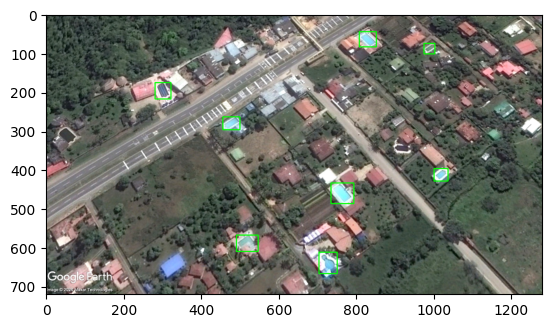

In [8]:
# Applying the transformations
transformed = transforms(image=image, bboxes=bboxes)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']

# Ploting the transformed image with its respective transformed bboxes
plot_bboxes(transformed_image, transformed_bboxes)

### Data Augmentation

In [9]:
import os

workingDir = '/content/DatasetYOLO/css-data/'

images_list = os.listdir(os.path.join(workingDir, 'train/images'))
labels_list = os.listdir(os.path.join(workingDir, 'train/labels'))

augmented_images_path = os.path.join(workingDir, 'augmented_data/images/')
augmented_labels_path = os.path.join(workingDir, 'augmented_data/labels/')

if not os.path.exists(augmented_images_path):
  os.makedirs(augmented_images_path)

if not os.path.exists(augmented_labels_path):
  os.makedirs(augmented_labels_path)

In [10]:
# Transforming every image in the original dataset
for image_path, labels_path in zip(images_list, labels_list):

  image = cv2.imread(os.path.join(workingDir, 'train/images/', image_path))  # image
  with open(os.path.join(workingDir, 'train/labels/', labels_path), "r") as f:
    bboxes = f.readlines()  # bboxes

  bboxes = [bbox.split() for bbox in bboxes]  # [class, x_center, y_center, width, height]  YOLO format
  bboxes = [[float(bbox[1]), float(bbox[2]), float(bbox[3]), float(bbox[4]), int(bbox[0])] for bbox in bboxes]

  for i in range(5):  # Generating 5 variations of each image

    transformed = transforms(image=image, bboxes=bboxes)
    transformed_image = transformed['image']  # new image
    transformed_bboxes = transformed['bboxes']  # new bboxes

    new_bboxes = [[bbox[-1], bbox[0], bbox[1], bbox[2], bbox[3]] for bbox in transformed_bboxes]

    # Save the transformed image in the new directory
    new_image_path = os.path.join(augmented_images_path, 'new' + str(i) + '_' + image_path)
    cv2.imwrite(new_image_path, transformed_image)

    # Save the transformed bboxes in a new txt file
    new_labels_path = os.path.join(augmented_labels_path, 'new' + str(i) + '_' + labels_path)
    with open(new_labels_path, 'w') as f:
      for bbox in new_bboxes:
        f.write(' '.join(map(str, bbox)) + '\n')

In [11]:
new_images_list = os.listdir(os.path.join(workingDir, 'augmented_data/images'))
new_labels_list = os.listdir(os.path.join(workingDir, 'augmented_data/labels'))

print(len(new_images_list), len(new_labels_list))  # Now we have obtained 500 images from the original ones

500 500


In [12]:
paths = []

# Creating the new directories for YOLOv8 Model

new_train_images_path = os.path.join(workingDir, 'new_train/images/')
paths.append(new_train_images_path)
new_train_labels_path = os.path.join(workingDir, 'new_train/labels/')
paths.append(new_train_labels_path)
new_test_images_path = os.path.join(workingDir, 'test/images/')
paths.append(new_test_images_path)
new_test_labels_path = os.path.join(workingDir, 'test/labels/')
paths.append(new_test_labels_path)
new_valid_images_path = os.path.join(workingDir, 'valid/images/')
paths.append(new_valid_images_path)
new_valid_labels_path = os.path.join(workingDir, 'valid/labels/')
paths.append(new_valid_labels_path)

for path in paths:
  if not os.path.exists(path):
    os.makedirs(path)

In [13]:
train_frac = 0.75  # 75% of the images for training
valid_frac = 0.15  # 15% of the images for validation
test_frac = 0.1  # 10% of the images for testing

train_num = len(new_images_list) * 75 // 100
valid_num = len(new_images_list) * 15 // 100
test_num = len(new_images_list) * 10 // 100
print(train_num, valid_num, test_num)

375 75 50


In [14]:
import numpy as np

for i in range(train_num):  # 75% of 500 (375)
  rnd_image = np.random.choice(new_images_list)  # selecting 75% of the images randomly for training set
  rnd_id = rnd_image[:-4]
  !cp {workingDir}augmented_data/images/{rnd_id}.jpg /content/DatasetYOLO/css-data/new_train/images/
  !cp {workingDir}augmented_data/labels/{rnd_id}.txt /content/DatasetYOLO/css-data/new_train/labels/
  new_images_list.remove(rnd_image)

In [15]:
print(len(new_images_list))  # 125 images least (500-375)

125


In [ ]:
for i in range(train_num):  # 15% of 500 (75)
  rnd_image = np.random.choice(new_images_list)  # selecting 15% of the images randomly for validation set
  rnd_id = rnd_image[:-4]
  !cp {workingDir}augmented_data/images/{rnd_id}.jpg /content/DatasetYOLO/css-data/valid/images/
  !cp {workingDir}augmented_data/labels/{rnd_id}.txt /content/DatasetYOLO/css-data/valid/labels/
  new_images_list.remove(rnd_image)

In [ ]:
print(len(new_images_list))  # 50 images least (125-75)

In [ ]:
for i in range(train_num):  # 10% of 500 (50)
  rnd_image = np.random.choice(new_images_list)  # selecting 10% of the images randomly for testing set
  rnd_id = rnd_image[:-4]
  !cp {workingDir}augmented_data/images/{rnd_id}.jpg /content/DatasetYOLO/css-data/test/images/
  !cp {workingDir}augmented_data/labels/{rnd_id}.txt /content/DatasetYOLO/css-data/test/labels/
  new_images_list.remove(rnd_image)

In [ ]:
print(len(new_images_list))  # 0 images must least

In [ ]:
# Deleting the previous directories
!rm -rf /content/DatasetYOLO/css-data/augmented_data/
!rm -rf /content/DatasetYOLO/css-data/train/

# Setting a new name for the directory with the augmented dataset
!mv /content/DatasetYOLO/css-data/new_train/ /content/DatasetYOLO/css-data/train/
!mv /content/DatasetYOLO/ /content/DatasetPoolDetection

In [ ]:
!zip -r /content/DatasetPoolDetection.zip /content/DatasetPoolDetection  # zip and download...